In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-and-cat-detection/annotations/Cats_Test2888.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1617.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test83.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test899.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1204.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test603.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test2365.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test380.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1300.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3380.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3246.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1979.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test147.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test3153.xml
/kaggle/input/dog-and-cat-detection/annotations/Cats_Test985.xml
/kaggle/input/dog

In [2]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [3]:
images_path = Path('../input/dog-and-cat-detection/images')
anno_path = Path('../input/dog-and-cat-detection/annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,cat,99,34,238,183
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,dog,183,92,291,259
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,155,119,356,250
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,193,85,305,179
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,dog,284,58,363,128
...,...,...,...,...,...,...,...,...
3681,../input/dog-and-cat-detection/images/Cats_Tes...,200,179,cat,1,73,110,178
3682,../input/dog-and-cat-detection/images/Cats_Tes...,300,238,cat,223,77,285,145
3683,../input/dog-and-cat-detection/images/Cats_Tes...,500,333,dog,187,1,468,256
3684,../input/dog-and-cat-detection/images/Cats_Tes...,500,359,cat,215,23,393,176


In [5]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])


In [6]:
df_train["class"].value_counts()

1    2498
0    1188
Name: class, dtype: int64

In [7]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)



def crop(im, r, c, target_r, target_c): 
    """Вырезаем кусок с изображения"""
    return im[r:r+target_r, c:c+target_c]

def center_crop(x, r_pix=8):
    """Центральное вырезание """
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def transformsXY(path, bb, is_transforms):
    """Трансформируем нашу картинку"""
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [8]:
IM_SIZE = 300

In [9]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,0,99,34,238,183,images_resized/Cats_Test2888.png,"[32.0, 94.0, 177.0, 228.0]"
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,1,183,92,291,259,images_resized/Cats_Test1617.png,"[66.0, 110.0, 186.0, 174.0]"
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,155,119,356,250,images_resized/Cats_Test83.png,"[95.0, 93.0, 199.0, 213.0]"
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,193,85,305,179,images_resized/Cats_Test899.png,"[68.0, 116.0, 143.0, 182.0]"
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,1,284,58,363,128,images_resized/Cats_Test1204.png,"[52.0, 170.0, 114.0, 217.0]"


(500, 375, 3)


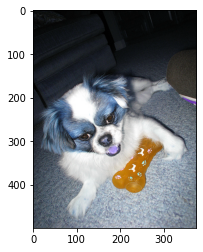

In [10]:
im = cv2.imread(str(df_train.values[20][0]))
bb = create_bb_array(df_train.values[20])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

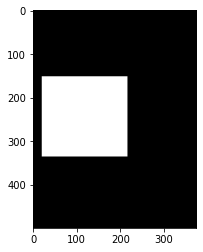

In [11]:
plt.imshow(Y, cmap='gray')

In [12]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized/Cats_Test2466.png


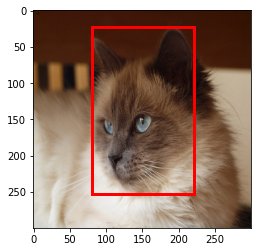

In [13]:
number = 45
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

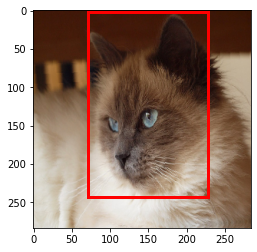

In [14]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

In [15]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train)#, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [16]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [17]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.vgg19(pretrained=True)
        layers = list(resnet.children())[:1]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [18]:
resnet = models.vgg19(pretrained=True)
list(resnet.children())[:1]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace=T

In [19]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
epochs = 30
model

BB_model(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [20]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [21]:
train()

Epoch [1/30]. train_loss 484.090 val_loss 482.601 val_acc 0.991
Epoch [2/30]. train_loss 481.520 val_loss 479.717 val_acc 0.995
Epoch [3/30]. train_loss 476.107 val_loss 484.605 val_acc 0.878
Epoch [4/30]. train_loss 467.417 val_loss 458.671 val_acc 0.986
Epoch [5/30]. train_loss 455.598 val_loss 434.627 val_acc 0.963
Epoch [6/30]. train_loss 440.641 val_loss 417.196 val_acc 0.984
Epoch [7/30]. train_loss 423.074 val_loss 420.652 val_acc 0.984
Epoch [8/30]. train_loss 403.675 val_loss 414.555 val_acc 0.907
Epoch [9/30]. train_loss 381.917 val_loss 379.400 val_acc 0.976
Epoch [10/30]. train_loss 360.218 val_loss 314.746 val_acc 0.959
Epoch [11/30]. train_loss 336.804 val_loss 318.871 val_acc 0.965
Epoch [12/30]. train_loss 313.555 val_loss 294.668 val_acc 0.955
Epoch [13/30]. train_loss 290.364 val_loss 272.495 val_acc 0.959
Epoch [14/30]. train_loss 267.664 val_loss 230.223 val_acc 0.974
Epoch [15/30]. train_loss 245.046 val_loss 251.484 val_acc 0.977
Epoch [16/30]. train_loss 224.491 

In [30]:
# resizing test image
image = 'Cats_Test11'
im = read_image(f'./images_resized/{image}.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite(f'./road_signs_test/{image}.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [31]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':f'./road_signs_test/{image}.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [32]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 3.6095, -0.3569, -4.7615, -4.5310]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 19.1242,  76.7200, 192.7137, 193.2779]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [33]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([3.6095], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

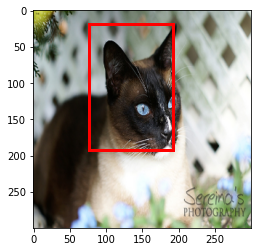

In [34]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])